<a href="https://colab.research.google.com/github/GusevMihail/seamless_textute_generator/blob/master/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path
import sys
if 'google' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir data
    !mkdir data/train
    if os.path.exists('data/train'):
        !cp /content/drive/MyDrive/Colab/seamless_textute_generator/data/concrete_maps.zip data
        !unzip -q -n data/concrete_maps.zip -d data/train

Mounted at /content/drive


In [37]:
from typing import Tuple, Any
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import cv2

In [20]:
data_folder = r'data/train'
image_names = tuple(f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f)))


In [65]:
from torch.utils import data
from PIL import Image

class TextureDataset(data.Dataset):

    def __init__(self, root_path: str, file_list: list, transforms: Any=None, 
                 cross_koeff: float=0.1, im_size: Tuple[int, int]=(224, 224)):
        super().__init__()
        self.root_path = root_path
        self.file_list = file_list
        self.transforms = transforms
        self.im_size = im_size
        self.cross_coeff = cross_koeff

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index: int) -> Tuple[np.array, np.array]:
        # if index > len(self.file_list):
        #     print('invalid index!')
        #     return self.__getitem__(np.random.randint(0, self.__len__()))

        image_path = os.path.join(self.root_path, self.file_list[index])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X, mask = self.cut_cross(image)

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed['image']
            # mask = transformed['mask']
        return X, mask, image
    
    def cut_cross(self, img: np.array)->Tuple[np.array, np.array]:
        height, width, _ = img.shape
        # Размеры креста
        cross_height = round(height * self.cross_coeff / 2)
        cross_width = round(width * self.cross_coeff / 2)

        # Индексы вырезания креста
        start_height_idx = round(height / 2 - cross_height)
        end_height_idx = round(height / 2 + cross_height)

        start_width_idx = round(width / 2 - cross_width)
        end_width_idx = round(width / 2 + cross_width)

        # Вырежем крест
        X = img.copy()
        X[start_height_idx : end_height_idx] = 0
        X[:, start_width_idx : end_width_idx] = 0
        # Определим маску креста
        mask = np.zeros(X.shape[:2]).astype(float)
        mask[start_height_idx : end_height_idx] = 1.
        mask[:, start_width_idx : end_width_idx] = 1.
        return X, mask
        
    # TODO: Возможно не пригодится
    def random_crop(self, img: np.array)-> np.array:
        height, width, _ = img.shape
        if height < self.im_size[0] or width < self.im_size[1]:
            img = cv2.resize((max(height, self.im_size[0]), (width, self.im_size[1])))
        
        start_height = np.random.randint(img.shape[0] - self.im_size[0])
        start_width = np.random.randint(img.shape[1] - self.im_size[1])
        return img[start_height : start_height + self.im_size[0], start_width : start_width + self.im_size[1]]

In [66]:
dataset = TextureDataset(data_folder, image_names)

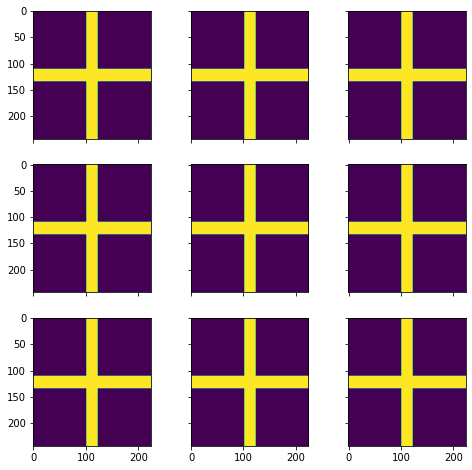

In [67]:
# look at the image
np.random.seed(42)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)

for fig_x in ax.flatten():
    i = np.random.choice(len(dataset), 1)[0]
    _, im, _ = dataset[i]

    im = cv2.resize(im, (224, 244))
    # print(im)
    fig_x.imshow(im)
    # if img_label is not None:
    #     fig_x.set_title(img_label)
    fig_x.grid(False)